<a href="https://colab.research.google.com/github/yy1200/COVID-19/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import csv
import pandas as pd
import numpy as np

#df = pd.read_csv("/content/covid-variants.csv",index_col='date',infer_datetime_format=True)
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d 'yamqwe/omicron-covid19-variant-daily-cases'

  0% 0.00/432k [00:00<?, ?B/s]
100% 432k/432k [00:00<00:00, 49.7MB/s]


In [4]:
! mkdir omicron-covid19
! unzip omicron-covid19-variant-daily-cases.zip -d omicron-covid19

Archive:  omicron-covid19-variant-daily-cases.zip
  inflating: omicron-covid19/covid-variants.csv  


In [5]:
df = pd.read_csv('omicron-covid19/covid-variants.csv')
df

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
0,Angola,2020-07-06,Alpha,0,0.0,3
1,Angola,2020-07-06,B.1.1.277,0,0.0,3
2,Angola,2020-07-06,B.1.1.302,0,0.0,3
3,Angola,2020-07-06,B.1.1.519,0,0.0,3
4,Angola,2020-07-06,B.1.160,0,0.0,3
...,...,...,...,...,...,...
100411,Zimbabwe,2021-11-01,Omicron,0,0.0,6
100412,Zimbabwe,2021-11-01,S:677H.Robin1,0,0.0,6
100413,Zimbabwe,2021-11-01,S:677P.Pelican,0,0.0,6
100414,Zimbabwe,2021-11-01,others,0,0.0,6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100416 entries, 0 to 100415
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   location             100416 non-null  object 
 1   date                 100416 non-null  object 
 2   variant              100416 non-null  object 
 3   num_sequences        100416 non-null  int64  
 4   perc_sequences       100416 non-null  float64
 5   num_sequences_total  100416 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


In [7]:
df.describe()

,num_sequences,perc_sequences,num_sequences_total
count,100416.000000,100416.000000,100416.000000
mean,72.171676,6.154355,1509.582457
std,1669.262169,21.898989,8445.291772
min,0.000000,-0.010000,1.000000
25%,0.000000,0.000000,12.000000
50%,0.000000,0.000000,59.000000
75%,0.000000,0.000000,394.000000
max,142280.000000,100.000000,146170.000000


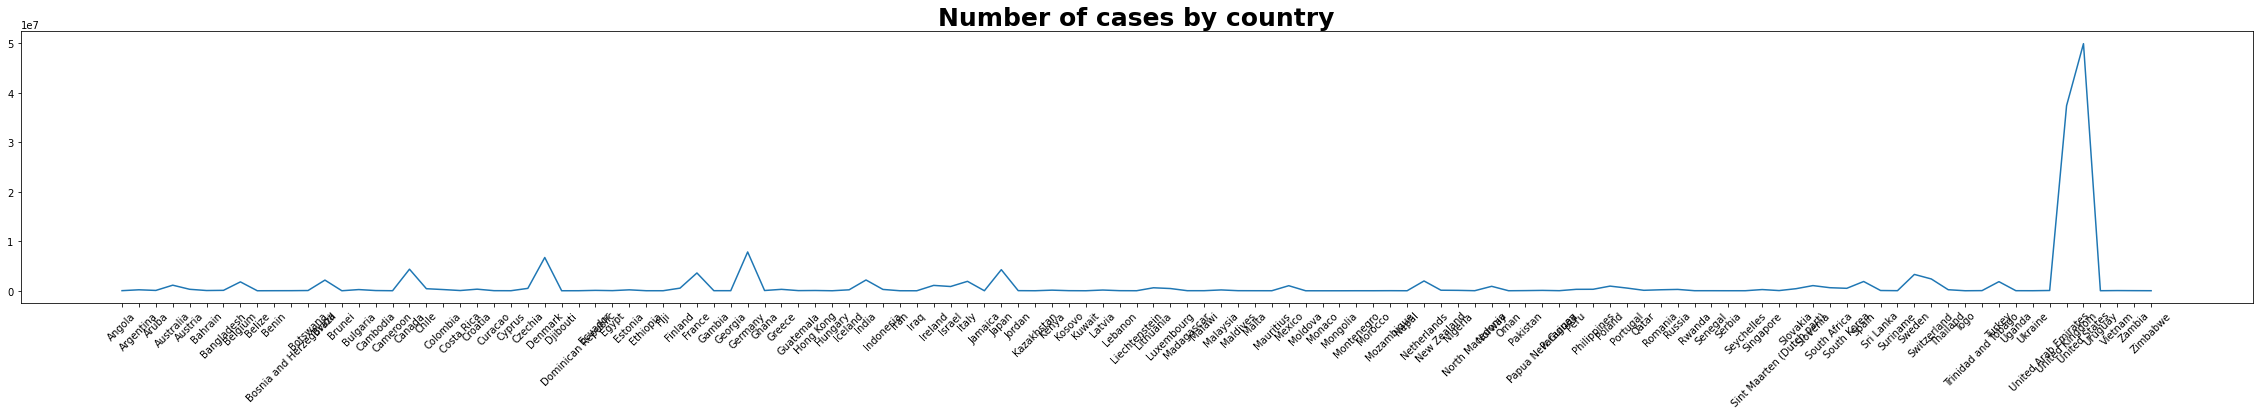

In [36]:
import matplotlib.pyplot as plt
Tnum=df.groupby('location')['num_sequences_total'].sum()
X=Tnum.keys()
Y=Tnum
plt.figure(figsize=(40,5))
plt.title('Number of cases by country',loc='center',fontweight="bold", fontsize=25)
plt.plot(X,Y)
plt.xticks(rotation=45)
plt.show()

In [9]:
country={'City':list(Tnum.keys())}
data = pd.DataFrame(country)
data
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
   
longitude = []
latitude = []
def findGeocode(city):  
  try:
    geolocator = Nominatim(user_agent="your_app_name")
    return geolocator.geocode(city)
  except GeocoderTimedOut:
    return findGeocode(city)
for i in (country["City"]):
  if findGeocode != None:
    loc = findGeocode(i)
    latitude.append(loc.latitude)
    longitude.append(loc.longitude)
  else:
    latitude.append(np.nan)
    longitude.append(np.nan)

In [10]:
country["Longitude"] = longitude
country["Latitude"] = latitude

country["Total numbers"]=Tnum
Ncountry=pd.DataFrame(country)
Ncountry

,City,Longitude,Latitude,Total numbers
location,,,,
Angola,Angola,17.569124,-11.877577,25320
Argentina,Argentina,-64.967282,-34.996496,201864
Aruba,Aruba,-69.960984,12.490300,72000
Australia,Australia,134.755000,-24.776109,1132776
Austria,Austria,14.124560,47.593970,301920
...,...,...,...,...
United States,United States,-100.445882,39.783730,49960248
Uruguay,Uruguay,-56.020153,-32.875555,16368
Vietnam,Vietnam,108.426511,13.290403,43320


In [11]:
t=Ncountry.sort_values(by=['Total numbers'],ascending=True)
t.head()

,City,Longitude,Latitude,Total numbers
location,,,,
Monaco,Monaco,7.424224,43.738449,2016
Mongolia,Mongolia,103.849974,46.825039,3600
Moldova,Moldova,28.567094,47.287961,3648
Iraq,Iraq,44.174977,33.095579,4008
Belize,Belize,-88.760093,16.825979,7536


In [39]:
import folium
from folium.plugins import MarkerCluster

world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)

for i in range(len(Ncountry)):
  lat = Ncountry.iloc[i]['Latitude']
  long = Ncountry.iloc[i]['Longitude']
  radius=5
  popup_text = """Country : {}<br>
              %of Tnums : {}<br>"""
  popup_text = popup_text.format(Ncountry.iloc[i]['City'],Ncountry.iloc[i]['Total numbers'])
  folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
display(world_map)

In [40]:
import numpy as np
from folium.plugins import HeatMap

fmap = folium.Map()
Ncountry["Percetage"]=Ncountry["Total numbers"]/Ncountry["Total numbers"].sum()*1000000
a=Ncountry[["Latitude","Longitude","Percetage"]]
#print(a)
city_list=a.values.tolist()
fmap.add_child(HeatMap(data=city_list,overlay=False,show=False))
display(fmap)

In [41]:
circle_map = folium.Map(location=[30, 15], zoom_start=2, tiles='OpenStreetMap')
for i in range(len(Ncountry)):
  lat = Ncountry.iloc[i]['Latitude']
  long = Ncountry.iloc[i]['Longitude']
  popup_text = """Country : {}<br>
            %of Tnums : {}<br>"""
  popup_text = popup_text.format(Ncountry.iloc[i]['City'],Ncountry.iloc[i]['Total numbers'])
  radius = Ncountry.iloc[i]["Total numbers"]/15
  folium.Circle(location = [lat, long],radius=radius,popup=popup_text,max_width='100',fill=True).add_to(circle_map)
display(circle_map)

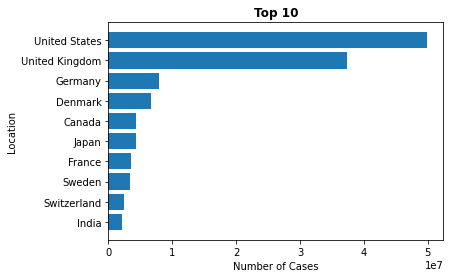

In [30]:
x=t.iloc[-10:,0]
y=t.iloc[-10:,3]
plt.title("Top 10",loc='center',fontweight="bold")
plt.xlabel("Number of Cases")
plt.ylabel("Location")
plt.barh(x,y)
plt.show()

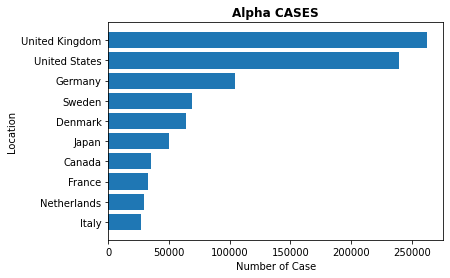

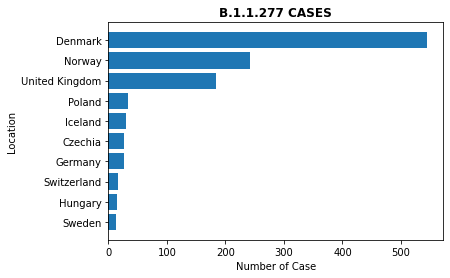

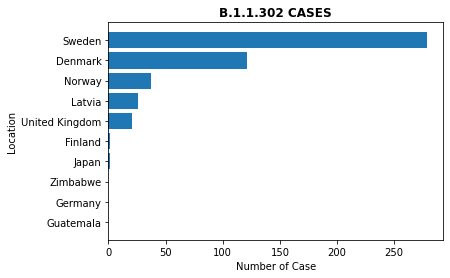

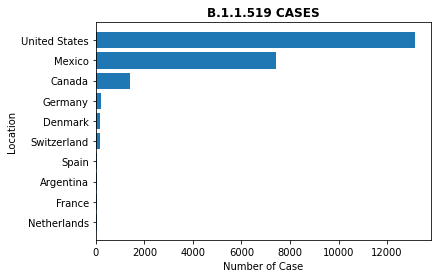

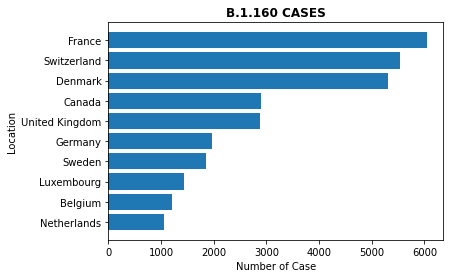

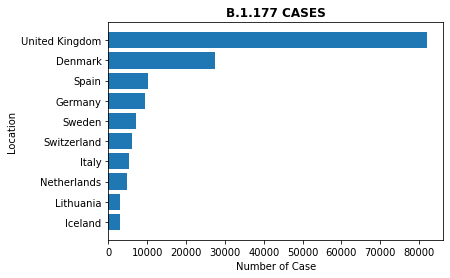

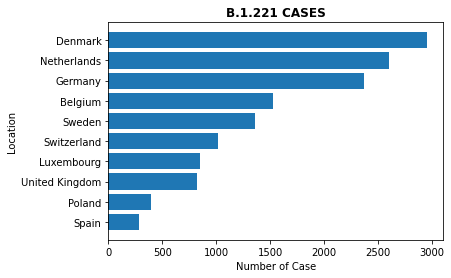

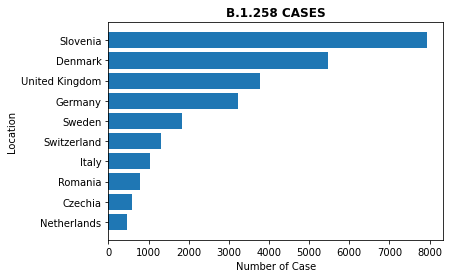

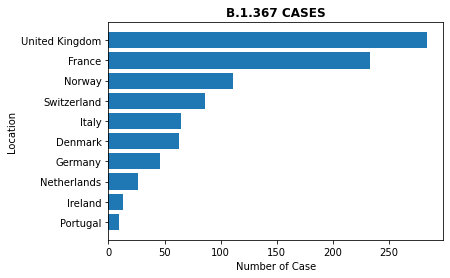

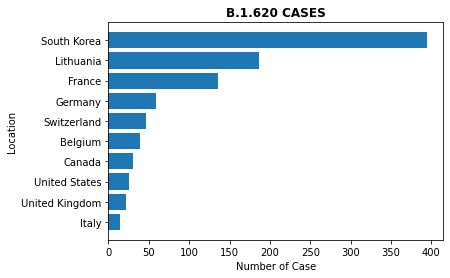

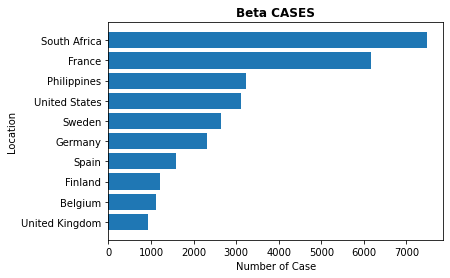

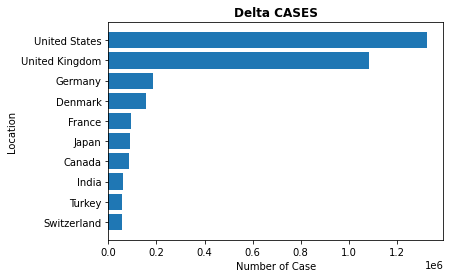

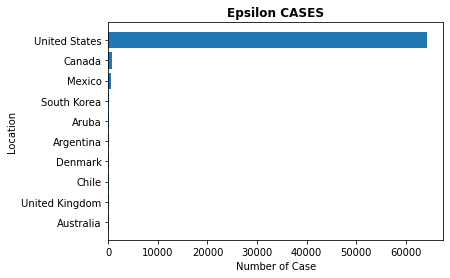

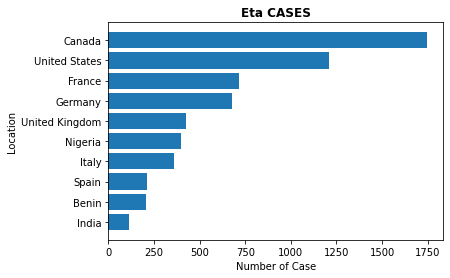

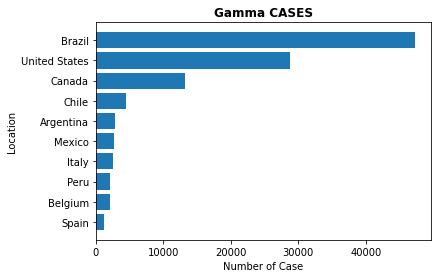

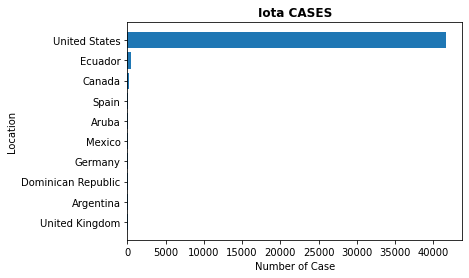

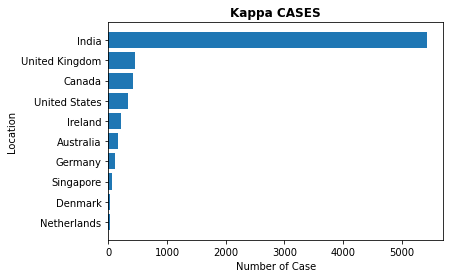

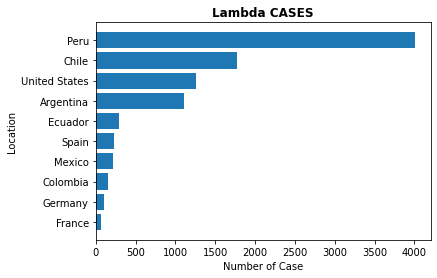

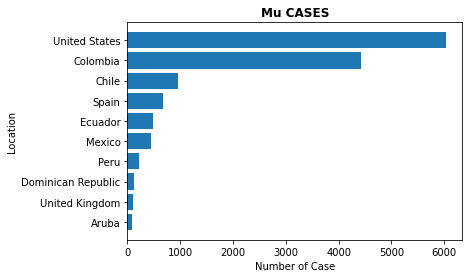

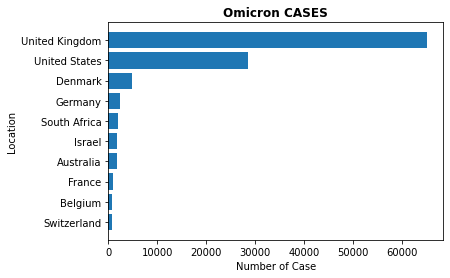

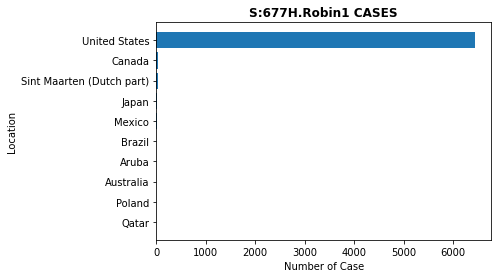

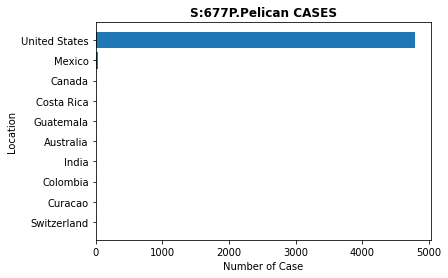

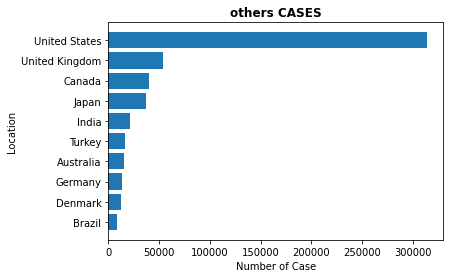

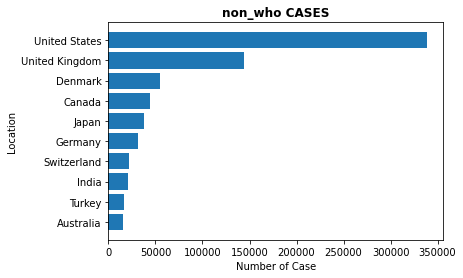

In [18]:
for virus in df.variant.unique():
  df1 = df.loc[df['variant'] == virus].groupby('location')['num_sequences'].agg('sum').sort_values(ascending=True)[-10:]
  #dataframe = pd.DataFrame({'Location':dataframe.index, 'Number of Case':dataframe.values})
  X=df1.keys()
  Y=df1[X]
  plt.barh(X,Y)
  plt.xlabel('Number of Case')
  plt.ylabel('Location')
  plt.title('{} CASES'.format(virus),loc='center',fontweight="bold")
  plt.show()

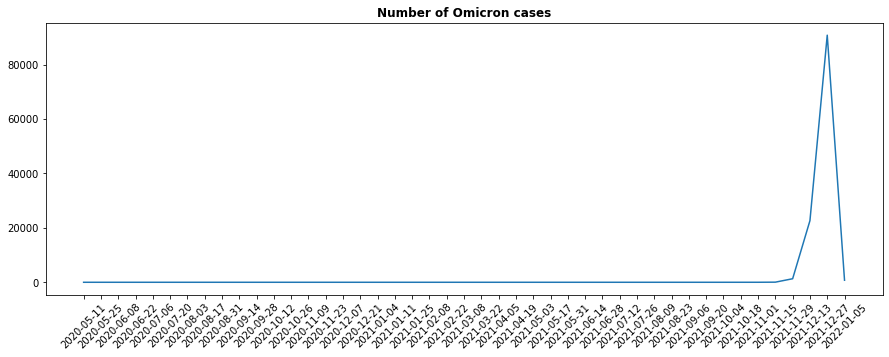

In [33]:
sample = df.loc[df['variant'] == 'Omicron'].groupby('date')['num_sequences'].agg('sum')
xo=sample.keys()
yo=sample[xo]
plt.figure(figsize=(15,5))
plt.title("Number of Omicron cases",loc='center',fontweight="bold")
plt.plot(xo,yo)
plt.xticks(rotation=45)
plt.show()

Covid Prediction

In [21]:
import csv
import pandas as pd
import numpy as np
df = pd.read_csv('omicron-covid19/covid-variants.csv')
df.set_index('date', inplace=True)
df

,location,variant,num_sequences,perc_sequences,num_sequences_total
date,,,,,
2020-07-06,Angola,Alpha,0,0.0,3
2020-07-06,Angola,B.1.1.277,0,0.0,3
2020-07-06,Angola,B.1.1.302,0,0.0,3
2020-07-06,Angola,B.1.1.519,0,0.0,3
2020-07-06,Angola,B.1.160,0,0.0,3
...,...,...,...,...,...
2021-11-01,Zimbabwe,Omicron,0,0.0,6
2021-11-01,Zimbabwe,S:677H.Robin1,0,0.0,6
2021-11-01,Zimbabwe,S:677P.Pelican,0,0.0,6


In [22]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

class COVID19_Forecasts:
  def __init__(self,length=80,batch_size=1):
    self.length = length
    self.batch_size = batch_size
    
  def model(self,length,batch_size,s_train,s_test):
    model = Sequential()
    model.add(LSTM(100, input_shape=(length,s_train.shape[1])))
    #model.add(LSTM(256, return_sequences=True))
    #model.add(TimeDistributed(Dense(1)))
    #model.add(Flatten())
    #model.add(Dense(5,activation='linear'))
    model.add(Dense(s_train.shape[1]))
    #model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    model.summary()
    early_stop = EarlyStopping(monitor='val_loss',patience=25)
    train_data_gen = TimeseriesGenerator(s_train, s_train, length=length, batch_size=batch_size, sampling_rate=1,stride=1) 
    test_data_gen = TimeseriesGenerator(s_test, s_test, length=length, batch_size=batch_size, sampling_rate=1,stride=1)
    history=model.fit(train_data_gen,epochs=100,validation_data=test_data_gen,callbacks=[early_stop]).history
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.show()
    return model,train_data_gen,test_data_gen

  def data_preb(self,data,index_size):
    data.sort_index(ascending=True,inplace=True)
    train = data.iloc[:index_size]
    test = data.iloc[index_size:]
    scaler = MinMaxScaler()
    scaler.fit(train)
    s_train = scaler.transform(train)
    s_test = scaler.transform(test)
    return scaler,s_train,s_test,train,test

In [23]:
covid = COVID19_Forecasts()

In [24]:
df['Time']=df.index
data=pd.DataFrame(df.groupby('Time')['num_sequences_total'].sum())
#data=data.drop(['location','variant','perc_sequences','num_sequences'],axis=1,inplace=True)
scaler,s_train,s_test,train,test = covid.data_preb(data,40)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
36/36 [==============================] - 3s 19ms/step - loss: 0.1020 - val_loss: 0.4380
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0353 - val_loss: 0.6374
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0313 - val_loss: 0.7740
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0289 - val_loss: 0.7027
Epoch 5/100
36/36 [==============================]

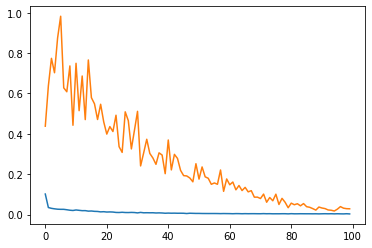

In [25]:
model,train_data_gen,test_data_gen = covid.model(length=4,batch_size=1,s_train=s_train,s_test=s_test)

In [26]:
score = model.evaluate(test_data_gen) 
trainPredict = model.predict(train_data_gen) 
testPredict = model.predict(test_data_gen)
print(score)

1/1 [==============================] - 0s 35ms/step - loss: 0.0290
0.029047157615423203


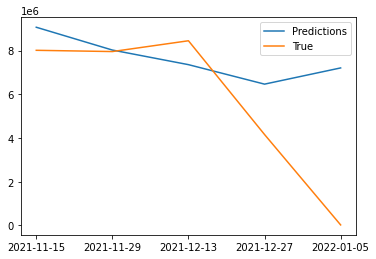

In [27]:
pred= scaler.inverse_transform(trainPredict)
Y=data.index
plt.plot(Y[-5:],pred[-5:],label="Predictions")
plt.plot(Y[-5:],data.values[-5:],label="True")
plt.legend()
plt.show()